Configuração inicial/ importação das principais libs usadas

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import sklearn
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

%matplotlib inline

Carregar os dados 

In [2]:
adult_train = pd.read_csv("/kaggle/input/adult-pmr3508/train_data.csv", na_values = "?")
adult_train.shape


(32560, 16)

In [3]:
adult_test = pd.read_csv("/kaggle/input/adult-pmr3508/test_data.csv", na_values = "?")
adult_test.shape

(16280, 15)

Informações adult Dataset

In [4]:
adult_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [5]:
adult_train.describe()

,Id,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Analise dos dados categóricos

In [6]:
adult_train.describe(exclude = [np.number])

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


EDA e Tratamento dos dados

Remover os dados faltantes

In [7]:
n_adult = adult_train.dropna()
n_adult.shape

(30161, 16)

Tratamento dos dados categóricos

In [8]:
cat = adult_train.describe(exclude = [np.number]).columns

categoricAdult = adult_train[cat].apply(pd.Categorical)

for col in cat:
    adult_train[col + "_cat"] = categoricAdult[col].cat.codes
categoricTestAdult = adult_test[cat[:-1]].apply(pd.Categorical)

for col in cat[:-1]:
    adult_test[col + "_cat"] = categoricTestAdult[col].cat.codes

In [9]:
adult_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,...,income,workclass_cat,education_cat,marital.status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native.country_cat,income_cat
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,...,<=50K,3,15,0,3,3,4,1,38,0
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,...,<=50K,1,0,2,13,0,4,1,38,0
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,...,<=50K,3,15,4,6,1,4,1,38,0
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,...,<=50K,3,15,0,0,1,4,0,38,0
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,...,>50K,4,11,2,13,0,4,1,17,1


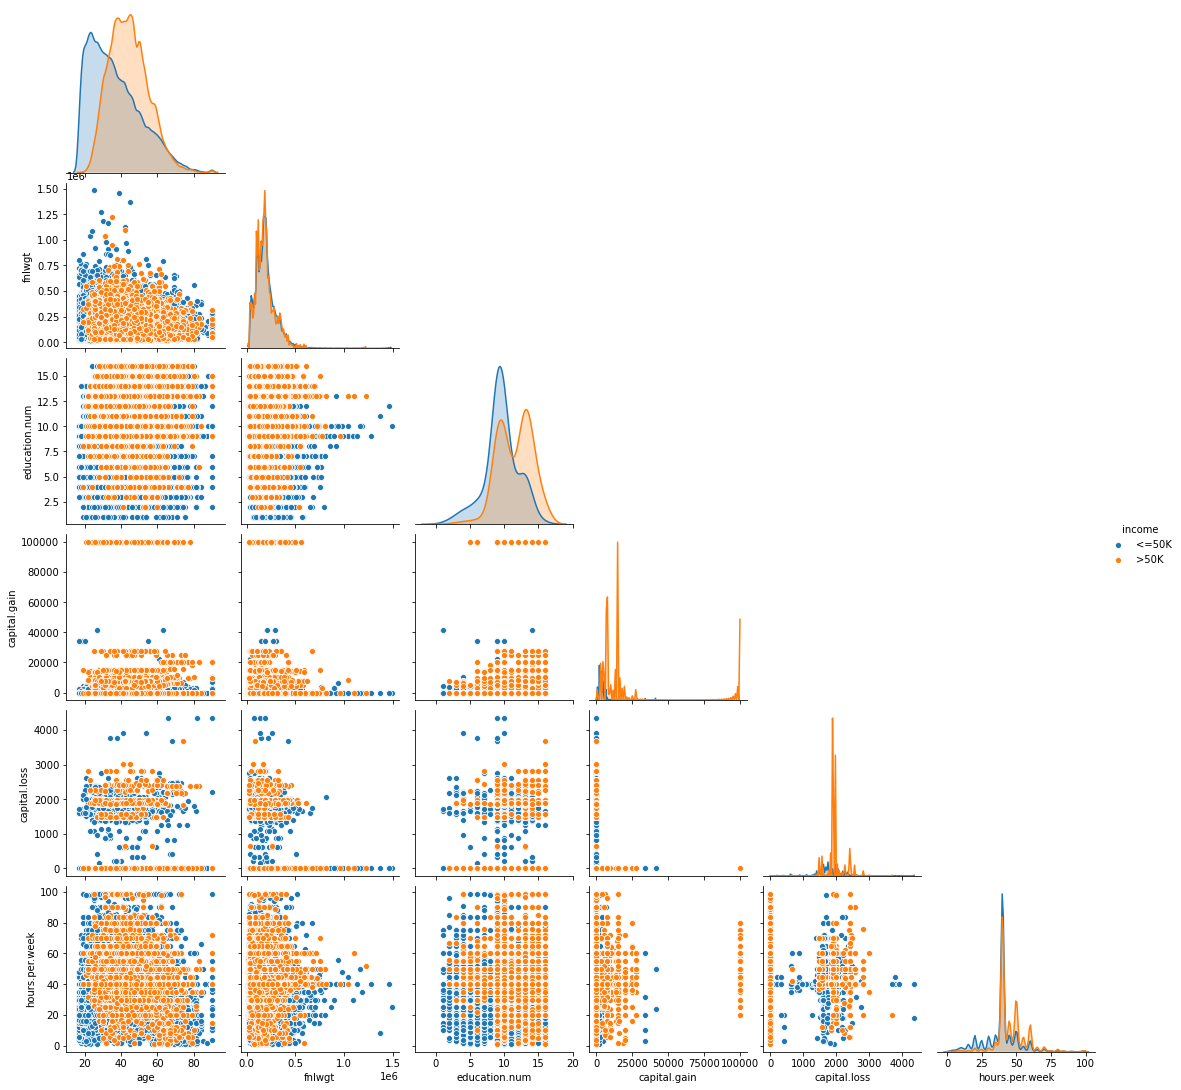

In [10]:
sns.pairplot(adult_train, vars=["age", "fnlwgt", "education.num", "capital.gain", "capital.loss", 
                          "hours.per.week"], hue="income", diag_kws={'bw':"1.0"}, corner=True)
plt.show()

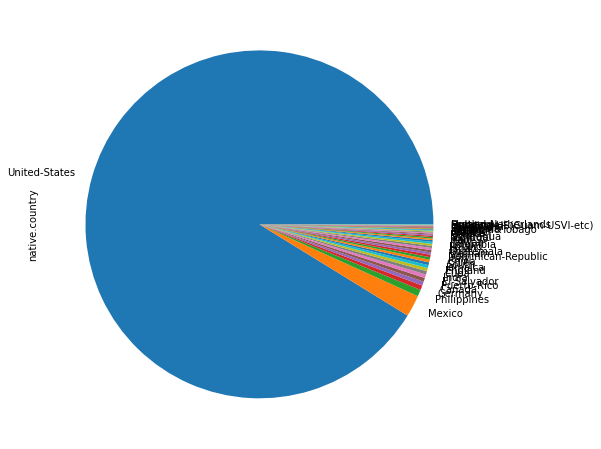

In [11]:
adult_train["native.country"].value_counts().plot(kind="pie", figsize = (8,8))
plt.show()

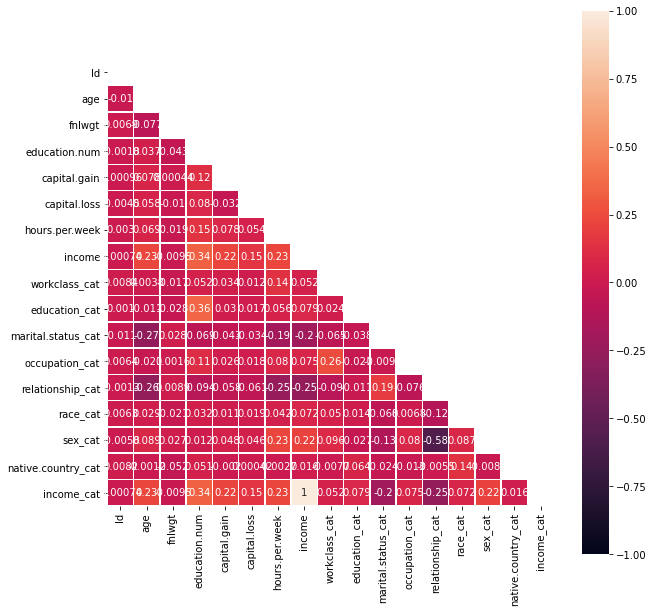

In [12]:
adult_copy = adult_train.copy()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
adult_copy["income"] = le.fit_transform(adult_copy['income'])

#heat map:
plt.figure(figsize=(10,10))
mask = np.zeros_like(adult_copy.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(adult_copy.corr(), square=True, vmin=-1, vmax=1, annot = True, linewidths=.5, mask=mask)
plt.show()

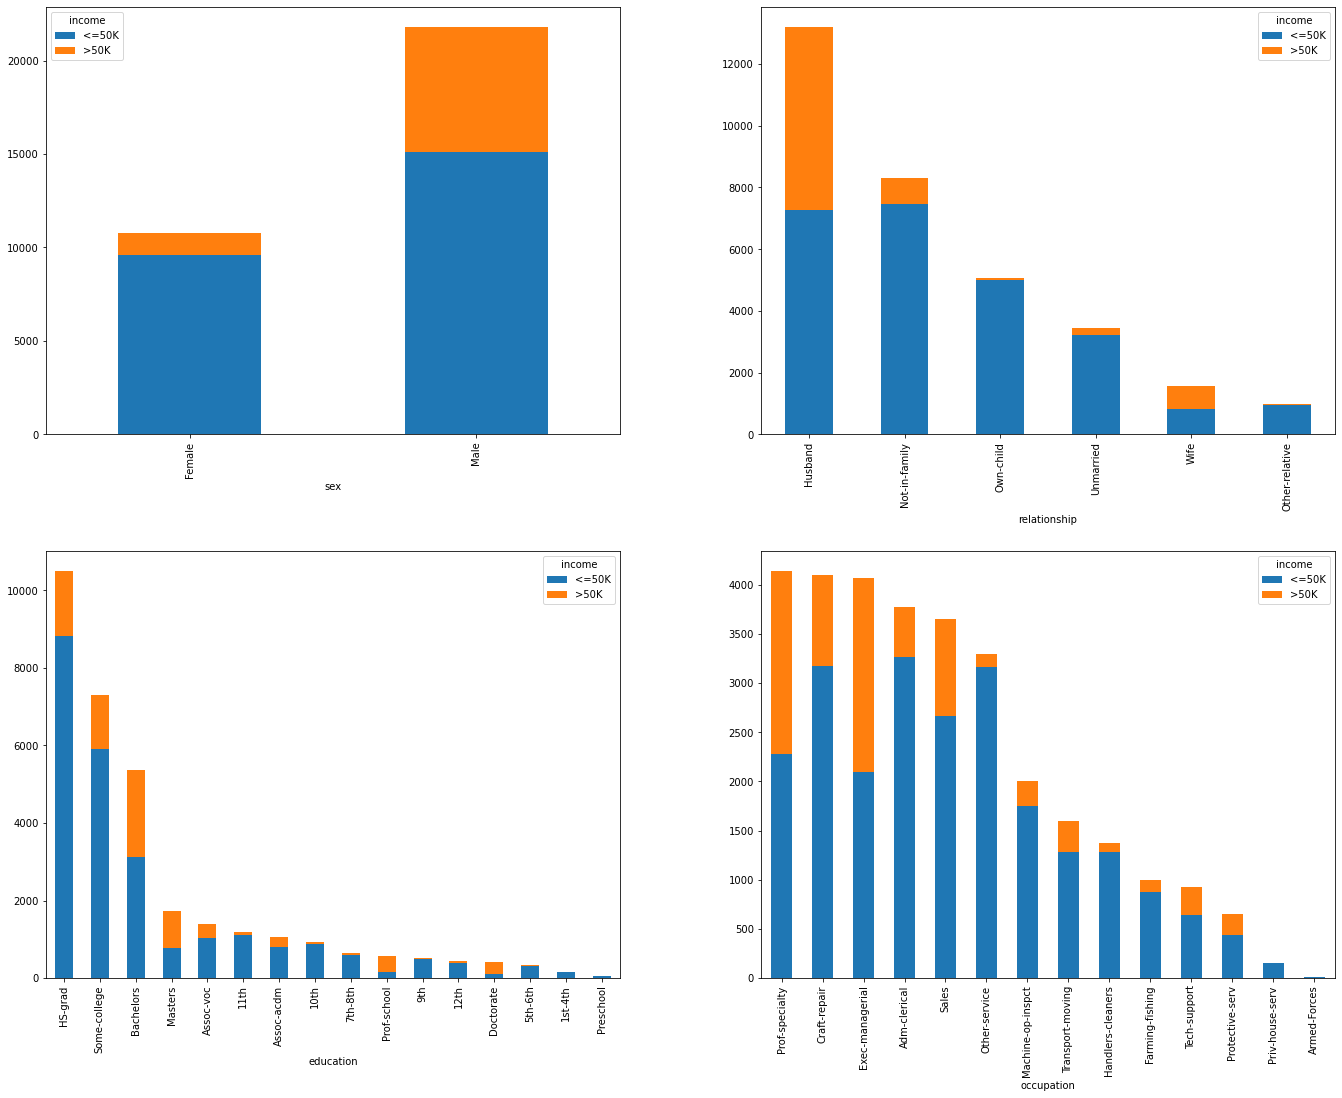

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout(pad = .4, w_pad = .5, h_pad = 1.)

adult_train.groupby(['sex', 'income']).size().unstack().plot(kind = 'bar', stacked = True, ax = axes[0, 0], figsize = (20, 15))

relationship = adult_train.groupby(['relationship', 'income']).size().unstack()
relationship['sum'] = adult_train.groupby('relationship').size()
relationship = relationship.sort_values('sum', ascending = False)[['<=50K', '>50K']]
relationship.plot(kind = 'bar', stacked = True, ax = axes[0, 1])

education = adult_train.groupby(['education', 'income']).size().unstack()
education['sum'] = adult_train.groupby('education').size()
education = education.sort_values('sum', ascending = False)[['<=50K', '>50K']]
education.plot(kind = 'bar', stacked = True, ax = axes[1, 0])

occupation = adult_train.groupby(['occupation', 'income']).size().unstack()
occupation['sum'] = adult_train.groupby('occupation').size()
occupation = occupation.sort_values('sum', ascending = False)[['<=50K', '>50K']]
occupation.plot(kind = 'bar', stacked = True, ax = axes[1, 1])



Selecçaõ dos principais atributos

In [14]:
princ_num_colum= ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
princ_cat_colum= ['occupation', 'relationship', 'sex','education']

In [15]:
X_train = adult_train[princ_num_colum + princ_cat_colum]
numX_train = adult_train[princ_num_colum + list(map(lambda x: x + "_cat", princ_cat_colum))]

X_test = adult_test[princ_num_colum + princ_cat_colum]
numXadul_test = adult_test[princ_num_colum + list(map(lambda x: x + "_cat", princ_cat_colum))]

Yadult = adult_train.income

Classificador KNN

In [16]:
classifiers = {}
scores = 0.0


for k in range(30, 35):
    knn = KNeighborsClassifier(k, metric = 'manhattan')
    score = np.mean(cross_val_score(knn, numX_train, Yadult, cv = 10))
    
    if score > scores:
        bestK = k
        scores = score
        classifiers['KNN'] = knn

        
classifiers['KNN'].fit(numX_train, Yadult)
        
print("Best acc: {}, K = {}".format(scores, bestK))

Best acc: 0.8531019656019655, K = 30


In [17]:
%%time

predictions = classifiers['KNN'].predict(numXadul_test)

CPU times: user 3.51 s, sys: 12.9 ms, total: 3.53 s
Wall time: 3.53 s


Preparação dos dados para envio da tarefa

In [18]:
id_index = pd.DataFrame({'Id' : list(range(len(predictions)))})
income = pd.DataFrame({'income' : predictions})
result = income

In [19]:
result.to_csv("submission.csv", index = True, index_label = 'Id')

Conclusão
Neste exercicio programa foi implementado a classificação KNN.
Obtendo uma acuracia de 85%